# NYSE Demo

### installing Python Dependencies

In [ ]:
%pip install --upgrade colorlog python-dotenv gpudb ipykernel ipywidgets langchain langchain-community mediapy nemollm pandas plotly typeguard

### Load up environment variables that contain our login credentials

In [1]:
from dotenv import load_dotenv
import importlib
import kinetica.kinetica_ctx as ctx
from kinetica.kinetica_ctx import KineticaTableDefinition, KineticaSamplesDefinition, KineticaContextBuilder
import os

load_dotenv()
user     = '<YOUR_USERNAME_HERE>'
password = '<YOUR_PASSWORD_HERE>'
host     = 'https://demo72.kinetica.com/_gpudb/'

importlib.reload(ctx)

<module 'kinetica.kinetica_ctx' from '/Users/Nima/Desktop/kinetica_demos/kinetica/kinetica_ctx.py'>

### Set the SQL context that we will be using

In [2]:
from gpudb import GPUdb
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.chat_models.kinetica import ChatKinetica, KineticaSqlOutputParser, KineticaSqlResponse, KineticaUtil
import uuid

# We want to have our own individual context to work with, so create an extension to the context name as shown here
extension: str = str(uuid.uuid4()).replace('-', '_')

# Set the SQL context to use
kinetica_ctx: str = f'nyse.nyse_vector_ctxt_{extension}'

# create the Kinetica connection
kdbc: GPUdb = KineticaUtil.create_kdbc(url=host, user=user, passwd=password)

In [3]:
nyse_prices_table_ctx = KineticaTableDefinition(
    table='nyse.prices',
    comment='Stock prices including ask, bid, and sale price and size',
    rules = [
        'when I ask about stock prices, use the nyse.prices table',
        'when I ask about stock prices today, filter on all results that occurred between now and an interval of 1 day',
        'all stock symbols are in lower case',
        'when I ask about today I mean that the timestamp should be greater than or equal to now minus an interval of 1 day',
        'when I ask about any column, make sure there are no null values or NaN values',
        'replace all NaN values with 0 using the IFNAN() function',
        'all numeric results should be larger than 0',
        'convert all stock symbols to lower case',
        'always filter out null values'
    ],
    annotations = dict(
        ap = 'ask price',
        bp = 'bid price',
        bs = 'bid size',
        lp = 'sale price',
        ls = 'sale size',
        s  = 'symbol',
        t  = 'timestamp'
    )
)

nyse_vector_table_ctx = KineticaTableDefinition(
    table='nyse.vector',
    comment='Time-series vector embeddings for NYSE stock characteristics'
)

samples_ctx = KineticaSamplesDefinition({
    '''find all sofi stock trades between 2024-01-29 14:25:00 and 2024-01-29 14:35:00 where the price is not null''' :
    '''
        SELECT t, s, lp
        FROM nyse.prices
        WHERE s ='sofi'
        AND t BETWEEN '2024-01-29 14:25:00' AND '2024-01-29 14:35:00'
        AND lp IS NOT NULL;
    ''',

    '''find similar patterns to sofi at 2024-01-29 14:25:00.000''' :
    '''
        SELECT
            ts_bkt,
            symbol,
            dot_product(ap_vec,(select string(ap_vec) from (select * from nyse.vector where ts_bkt = '2024-01-29 14:25:00.000' and symbol = 'sofi' limit 1))) as d1
        FROM
            nyse.vector
        ORDER BY
            d1 asc
        LIMIT
            5;
    ''',
    '''test amparo how many rows are in the prices data?''' :
    '''
        select
            count(*)
        from
            nyse.prices;
    ''',
  
    '''show me buying opportunities for the next 15 min''' :
    '''
        SELECT
            ts_bkt,
            symbol,
            dot_product(ap_vec,(select string(ap_vec) from (select * from nyse.vector where ts_bkt = '2024-01-29 14:25:00.000' and symbol = 'sofi' limit 1))) as d1
        FROM
            nyse.vector
        WHERE
            ts_bkt >= now() - interval '15' minutes
        ORDER BY
            d1 asc
        LIMIT
            5;
    ''',

    '''what stock symbol other than QQQ has the highest price within the last 15 minutes?''' :
    '''
        SELECT
            s
        FROM
            nyse.prices
        WHERE
            t >= now() - interval '15' minutes
            and s <> 'qqq'
        GROUP BY
            s
        ORDER BY
            avg(lp) desc
        LIMIT
            1;
    ''',
    '''Show me a top 25 list of stocks from today whose value increased by at least 12%''' :
    '''
        SELECT
            s,
            price_increase_percentage
        FROM
            (
                SELECT
                    s,
                    lp AS current_sale_price,
                    LAG(lp) OVER (PARTITION BY s ORDER BY t) AS previous_sale_price,
                    (((lp - LAG(lp) OVER (PARTITION BY s ORDER BY t)) / LAG(lp) OVER (PARTITION BY s ORDER BY t)) * 100) AS price_increase_percentage
                FROM 
                    nyse.prices
                WHERE
                    date(t) = '2024-01-23'
                    AND lp IS NOT NULL) AS PriceChanges
        WHERE
            price_increase_percentage > 12
        ORDER BY
            price_increase_percentage desc
        LIMIT 25;
    '''
})

sqlcontext = KineticaContextBuilder.context_str(name=kinetica_ctx, ctx_list=[nyse_prices_table_ctx, nyse_vector_table_ctx, samples_ctx])
kdbc.execute(sqlcontext)

1

### Set up our LLM with the Langchain framework

In [4]:
# create the Kinetica LLM
kinetica_llm = ChatKinetica(kdbc=kdbc)

# load the context from the database
ctx_messages = kinetica_llm.load_messages_from_context(kinetica_ctx)

# Add the input prompt. This is where input question will be substituted.
ctx_messages.append(("human", "{input}"))

# Create the prompt template.
prompt_template = ChatPromptTemplate.from_messages(ctx_messages)
prompt_template.pretty_print()

# create the chain. 
# note: The KineticaSqlOutputParser will execute the SQL statement and is optional.
chain = prompt_template | kinetica_llm | KineticaSqlOutputParser(kdbc=kdbc)
# for error handling purposes, we are making it easy to troubleshoot the generated SQL
chain_sql_only = prompt_template | kinetica_llm

================================ System Message ================================

CREATE TABLE nyse.prices AS
(
   t DATETIME NOT NULL COMMENT 'timestamp',
   s VARCHAR (8, dict, shard_key) NOT NULL COMMENT 'symbol',
   type VARCHAR (4, dict) NOT NULL,
   ap REAL  COMMENT 'ask price',
   as INTEGER,
   bp REAL  COMMENT 'bid price',
   bs INTEGER  COMMENT 'bid size',
   lp REAL  COMMENT 'sale price',
   ls INTEGER  COMMENT 'sale size'
);
COMMENT ON TABLE nyse.prices IS 'Stock prices including ask, bid, and sale price and size';
-- When querying table nyse.prices the following rules apply:
-- * when I ask about stock prices, use the nyse.prices table
-- * when I ask about stock prices today, filter on all results that occurred between now and an interval of 1 day
-- * all stock symbols are in lower case
-- * when I ask about today I mean that the timestamp should be greater than or equal to now minus an interval of 1 day
-- * when I ask about any column, make sure there are no null value

### Simple queries in plain english

In [10]:
from IPython.display import display, HTML


question = {"input": '''show me a sample of the vector data'''}
try:
    response: KineticaSqlResponse = chain.invoke(question)
    df = response.dataframe
    if df is None:
        print('No records returned\n', response.sql)
    else:
        display(HTML(response.dataframe.to_html(index=False)))
        
except:
    response = chain_sql_only.invoke(question)
    print('Got an error from the SQL query:\n',response.content)

ts_bkt,symbol,ap_vec
2024-01-18 19:20:00,agi,"[0.7157128, 0.24307618, 1.0, 0.31836814, 12.311852, 0.0068143937, -0.41851786, -0.19839777, -0.25925925, 2.0, 2.0, 1.1140754, 0.083333336, 0.0, 0.0, 0.3312133, 1.1780972, 0.16666667, 0.97474235, 2.0, 0.6923077, 3.0]"
2024-01-18 19:20:00,rf,"[5.22299, 0.17355777, 8.0, 0.84007204, 17.851154, 0.01861802, 0.7437121, 0.8779936, -0.6923077, 2.0, 10.0, 1.6697112, 0.16666667, 0.0, 0.0, 0.73660153, 0.19634955, 0.1, 0.5486776, 2.0, 0.64, 4.0]"
2024-01-18 19:20:00,csx,"[17.156063, -0.010141926, 1.0, 0.81526804, 34.53108, 0.012893033, 0.53672105, 0.6918471, 0.30935252, 2.0, 33.0, 1.5210154, 0.041666668, 0.84615386, 0.15384616, 0.88331944, 0.049087387, 0.03448276, 0.4404318, 2.0, 0.557971, 3.0]"
2024-01-18 19:20:00,cprt,"[55.24041, 0.00086633745, 1.0, 1.0624288, 47.86036, 0.03185335, -0.6705102, -0.81177694, -0.4621514, 3.0, 98.0, 1.6115193, 0.11111111, 0.74418604, 0.1627907, 0.9805896, 0.024543693, 0.012658228, 0.15176305, 2.0, 0.332, 0.0]"
2024-01-18 19:20:00,cl,"[55.483887, 0.002795388, 1.0, 0.90458995, 80.59633, 0.024089143, -0.80239725, -0.6155988, -0.39285713, 2.0, 103.0, 1.3576953, 0.11111111, 0.79545456, 0.13636364, 0.9662218, 0.012271847, 0.010752688, 0.23587954, 2.0, 0.48534203, 3.0]"


In [11]:
question = {"input": '''how many rows have flowed into the prices data in the last 15 minutes?'''}
try:
    response: KineticaSqlResponse = chain.invoke(question)
    df = response.dataframe
    if df is None:
        print('No records returned\n', response.sql)
    else:
        display(HTML(response.dataframe.to_html(index=False)))
        
except:
    response = chain_sql_only.invoke(question)
    print('Got an error from the SQL query:\n',response.content)

EXPR_0
96924


### Vector Similarity Search

In [12]:
question = {"input": '''what stock has traded with the highest volume of trades since the beginning of the day?'''}
try:
    response: KineticaSqlResponse = chain.invoke(question)
    df = response.dataframe
    if df is None:
        print('No records returned\n', response.sql)
    else:
        display(HTML(response.dataframe.to_html(index=False)))
        
except:
    response = chain_sql_only.invoke(question)
    print('Got an error from the SQL query:\n',response.content)

s
psq


In [13]:
import plotly.express as px


question = {"input": '''find all sofi stock trades between 2024-01-29 14:25:00 and 2024-01-29 14:35:00 where the price is recorded'''}
try:
    response: KineticaSqlResponse = chain.invoke(question)
    df = response.dataframe
    if df is None:
        print('No records returned\n', response.sql)
    else:
        fig = px.line(df, x="t", y="lp")
        fig.update_traces(line_color='blue', line_width=1)
        fig.show('jupyterlab')
        
except Exception as err:
    response = chain_sql_only.invoke(question)
    print('Got an error from the SQL query:\n',response.content, err)

Got an error from the SQL query:
 SELECT t, s, lp
FROM nyse.prices
WHERE s ='sofi'
AND t BETWEEN '2024-01-29 14:25:00' AND '2024-01-29 14:35:00'
AND lp IS NOT NULL; Mime type rendering requires nbformat>=4.2.0 but it is not installed


In [14]:
question = {"input": '''find similar patterns to sofi at 2024-01-29 14:25:00'''}
try:
    response: KineticaSqlResponse = chain.invoke(question)
    df = response.dataframe
    if df is None:
        print('No records returned\n', response.sql)
    else:
        display(HTML(response.dataframe.to_html(index=False)))
        
except Exception as err:
    response = chain_sql_only.invoke(question)
    print('Got an error from the SQL query:\n',response.content, err)

ts_bkt,symbol,d1
2023-06-28 16:00:00,alny,-365788.03125
2023-06-27 13:30:00,tqqq,-356100.875
2023-12-20 19:50:00,qqq,-322043.25
2023-06-22 13:35:00,tqqq,-309997.6875
2023-07-13 13:30:00,tqqq,-307590.6875


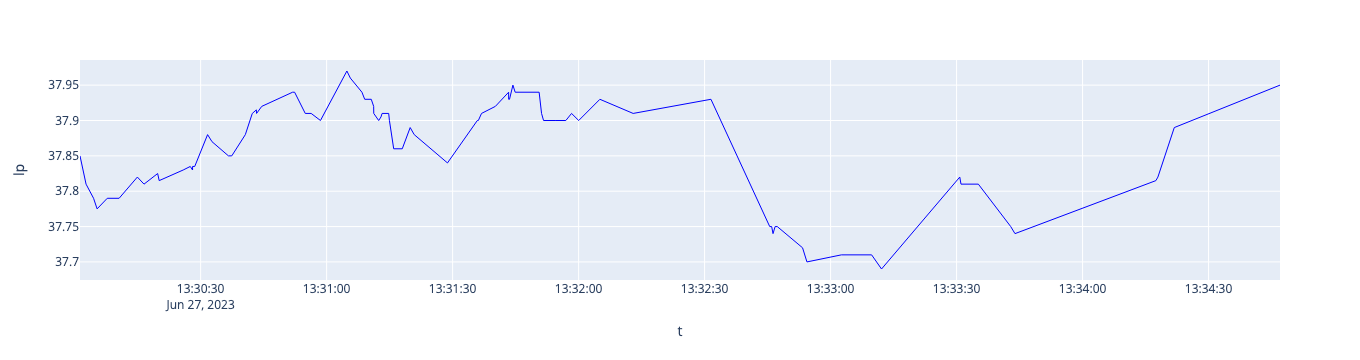

In [12]:
question = {"input": '''find all tqqq stock trades between 2023-06-27 13:30:00 and 2023-06-27 13:35:00 where the price is recorded'''}
try:
    response: KineticaSqlResponse = chain.invoke(question)
    df = response.dataframe
    if df is None:
        print('No records returned\n', response.sql)
    else:
        fig = px.line(df, x="t", y="lp")
        fig.update_traces(line_color='blue', line_width=1)
        fig.show('jupyterlab')
        
except Exception as err:
    response = chain_sql_only.invoke(question)
    print('Got an error from the SQL query:\n',response.content, err)

### Set up what we need for getting the SQLAssist LLM talking to a NeMo-backed LLM

In [15]:
import importlib
import kinetica.kineai
from kinetica.kineai import SqlAssistLLM

importlib.reload(kinetica.kineai)
kineticallm = kinetica.kineai.KineticaLLM(kinetica_ctx)

In [16]:
system = """ KineticAI is a cheerful AI assistant for engaging in a conversation between an LLM using the Nemo framework and the Kinetica LLM.  The Kinetica
LLM is designed to translate natural language questions into SQL queries. 

In addition to responding with  natural language it is able to ask questions to a database AI named SqlAssist that can query and summarize the logs. 
If it responds with a "KineticaLLM |  question" where question is sent to the SqlAssist AI. The SqlAssist AI will respond with an answer 
to the question in JSON format to the question made to SqlAssist by KineticAI.

when presented with a question, you should prefix your response with "KineticaLLM | "
if a sentence ends in a "?", you should prefix your response with "KineticaLLM | "

Consider the following example where a user asks KineticAI a question and KineticAI asks a followup question to SqlAssist. KineticAI uses the response from 
SqlAssist to answer the user's question.

user: what is the weather like today?
assistant: KineticaLLM | what is the weather like today?
user: KineticaLLM | [{"EXPR_0": 5.4}]
assistant: The answer is 5.4
"""

context0 = [dict(role="system", content=system),
            dict(role="user", content="what is the stock price today?"),
            dict(role="assistant", content="KineticaLLM | what is the stock price today?"),
            dict(role="user", content="how many rows of data are you storing?"),
            dict(role="assistant", content="KineticaLLM | how many rows of data are you storing?"),
            dict(role="user", content="what is the average number of telemetry rows per 5 second increment?"),
            dict(role="assistant", content="KineticaLLM | what is the average number of telemetry rows per 5 second increment?"),
            dict(role="user", content="find me top stock prices today"),
            dict(role="assistant", content="KineticaLLM | find me top stock prices today"),
            dict(role="user", content='KineticaLLM | [{"EXPR_0": 5.4}]'),
            dict(role="assistant", content='The answer is 5.4'),
            dict(role="user", content='KineticaLLM | [{"ts_bkt": "2024-02-07 19:35:00.000", "symbol": "aapl", "d1": -6467.2607421875}, {"ts_bkt": "2024-02-07 19:30:00.000", "symbol": "aapl", "d1": -6406.75341796875}, {"ts_bkt": "2024-02-07 19:45:00.000", "symbol": "tsla", "d1": -6331.88671875}, {"ts_bkt": "2024-02-07 19:40:00.000", "symbol": "tsla", "d1": -6128.375}]'),
            dict(role="assistant", content='It looks like aapl and tsla might be good choices')]

In [17]:
question = 'what stock symbol other than Apple has the highest price within the last 12 hours?'
kineticallm.chat(context0, question)

INFO:NemoChatLLM:user: KineticaLLM |  [{"s": "nvr"}] (tokens: 1204/2892)
INFO:NemoChatLLM:assistant: NVR is a good choice (tokens: 1283/2813)


[{'role': 'system',
  'content': ' KineticAI is a cheerful AI assistant for engaging in a conversation between an LLM using the Nemo framework and the Kinetica LLM.  The Kinetica\nLLM is designed to translate natural language questions into SQL queries. \n\nIn addition to responding with  natural language it is able to ask questions to a database AI named SqlAssist that can query and summarize the logs. \nIf it responds with a "KineticaLLM |  question" where question is sent to the SqlAssist AI. The SqlAssist AI will respond with an answer \nto the question in JSON format to the question made to SqlAssist by KineticAI.\n\nwhen presented with a question, you should prefix your response with "KineticaLLM | "\nif a sentence ends in a "?", you should prefix your response with "KineticaLLM | "\n\nConsider the following example where a user asks KineticAI a question and KineticAI asks a followup question to SqlAssist. KineticAI uses the response from \nSqlAssist to answer the user\'s questio

In [ ]:
question = 'find potential buying opportunities over the next 12 hours?'
kineticallm.chat(context0, question)

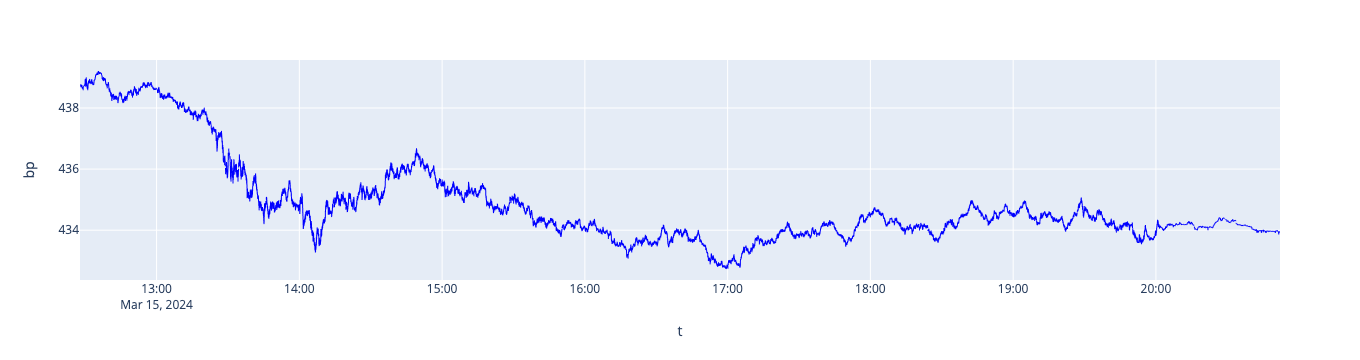

In [30]:
question = {"input": 'show me bid prices for qqq for the last 24 hours'}
\
try:
    response: KineticaSqlResponse = chain.invoke(question)
    df = response.dataframe
    if df is None:
        print('No records returned\n', response.sql)
    else:
        fig = px.line(df, x="t", y="bp")
        fig.update_traces(line_color='blue', line_width=1)
        fig.show('jupyterlab')
        
except Exception as err:
    response = chain_sql_only.invoke(question)
    print('Got an error from the SQL query:\n',response.content, err)

In [31]:
sql = f'drop context {kinetica_ctx}'
kdbc.execute(sql)

1